# ConvLSTM 
> Conv lstm model

In [1]:
from fastai.vision.all import *
from action_recognition.core import *
from action_recognition.models import *

In [2]:
set_seed(2021)

In [3]:
torch.cuda.set_device(1)
torch.cuda.get_device_name()

RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [4]:
data_path = Path.home()/'.fastai/data/UCF101-frames'

In [5]:
instances = get_instances(data_path)

## Params

In [6]:
seq_len = 20
step=5
image_size = 128
bs = 16
val_idxs = None

you could put this split on a text file:

In [7]:
dls = get_action_dataloaders(instances, bs=bs, image_size=image_size, seq_len=seq_len, step=step, val_idxs=val_idxs)

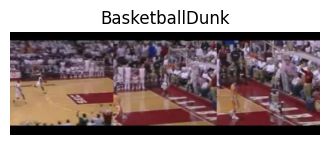

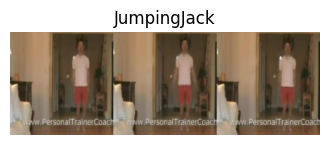

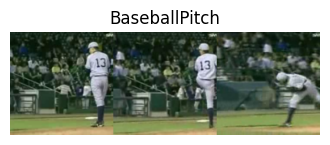

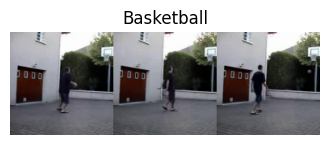

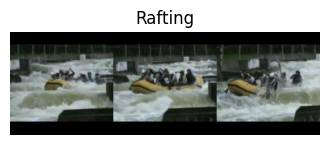

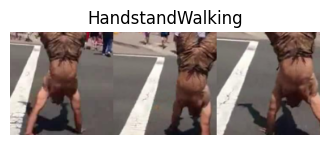

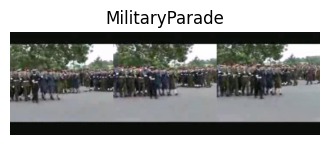

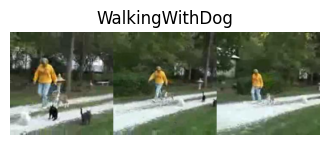

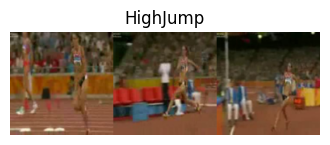

In [8]:
dls.show_batch()

## Train without attention
> We will predict over the hidden state of the sequence.

In [9]:
model = ConvLSTM(num_classes=dls.c, hidden_dim=256, lstm_layers=2, bidirectional=False, attention=False)

/home/pmishra/.local/lib/python3.8/site-packages/fastai/vision/learner.py:295: UserWarning: `create_cnn_model` has been renamed to `create_vision_model` -- please update your code
  warn("`create_cnn_model` has been renamed to `create_vision_model` -- please update your code")


In [10]:
learn = Learner(dls, model, metrics=[accuracy, top_k_accuracy], wd=0.1, cbs=[ModelResetter()], splitter=convlstm_splitter).to_fp16()
learn.freeze()

SuggestedLRs(valley=0.0005754399462603033)

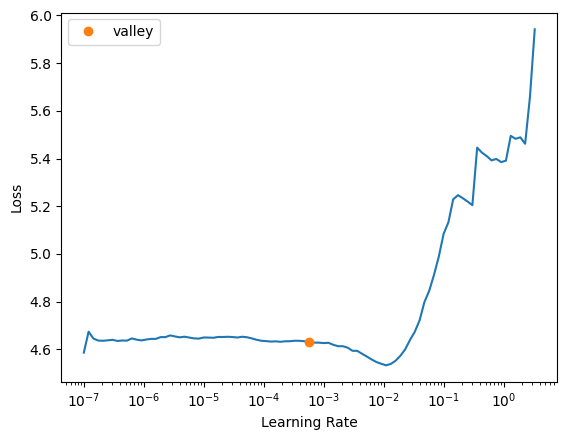

In [11]:
learn.lr_find()

In [12]:
learn.fit_one_cycle(10, 5e-3)

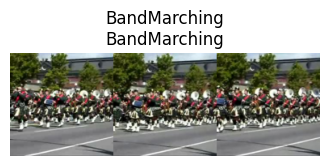

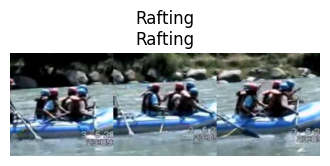

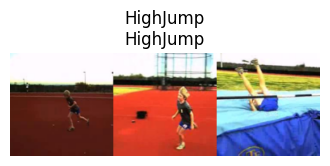

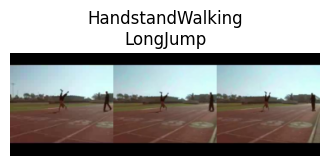

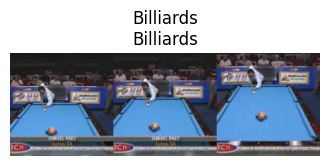

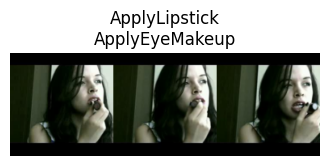

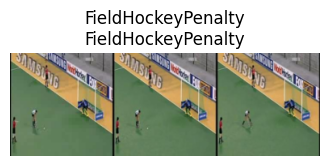

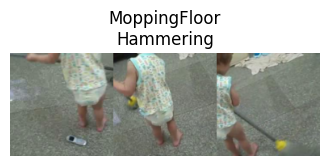

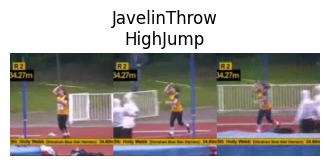

In [13]:
learn.show_results()

In [14]:
learn.validate()

(#3) [1.1755090951919556,0.6602852940559387,0.9084084033966064]

## Train with attention
> We will predict with an attention layer over the full output sequence from the LSTM layer.

In [15]:
model2 = ConvLSTM(num_classes=dls.c, hidden_dim=256, lstm_layers=2, bidirectional=True, attention=True)

In [16]:
learn2 = Learner(dls, model2, metrics=[accuracy, top_k_accuracy], wd=0.1, cbs=[ModelResetter()], splitter=convlstm_splitter).to_fp16()
learn2.freeze()

SuggestedLRs(valley=0.0005754399462603033)

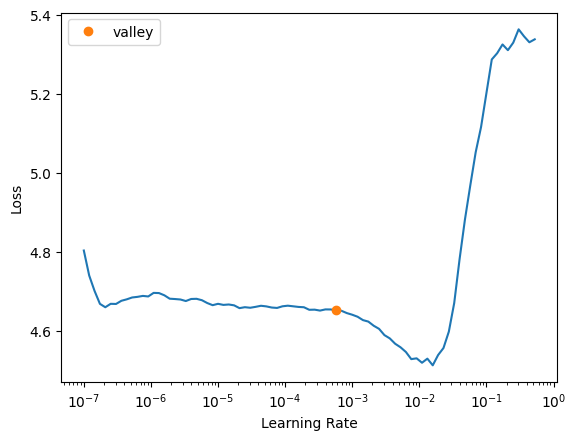

In [17]:
learn2.lr_find()

In [18]:
learn2.fit_one_cycle(10, 5e-3)

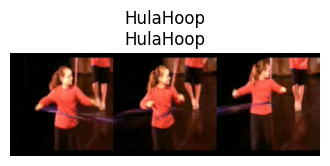

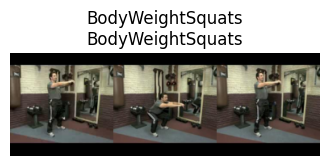

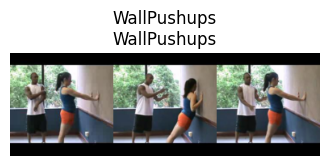

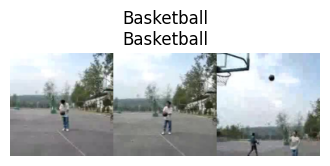

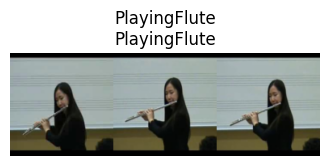

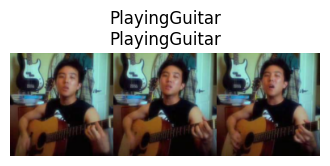

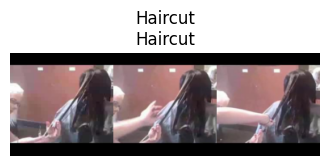

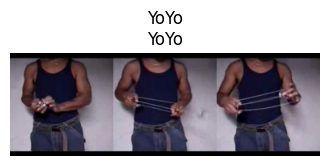

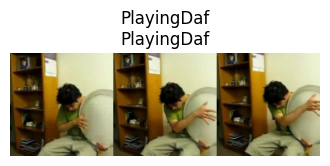

In [19]:
learn2.show_results()

In [20]:
learn2.validate()

(#3) [0.5452029705047607,0.8389639854431152,0.9699699878692627]